# Facial Emotion Recognition in Visual Data

This notebook is a base module providing Emotional Awareness for an Embodied Conversational Agent developed in context of Affective Computing (CMPT 419 with Dr.Angelica Lim)

The following Emotional Feature datasets are chosen for the project:<br>
- Cohn Kanade Extended Dataset
- Microsoft FER+ (2013)

### Outline:
- CK+ Dataset Loading
- Training a ConvNet using Keras
- Evaluation

- FER+ Dataset Loading
- Training a ConvNet using Keras
- Evaluation

In [3]:
import os
import pandas as pd
import numpy as np
import h5py

# Model-Related
import tensorflow as tf
from tensorflow.keras import layers

# Graphics and Plotting
import pydot, graphviz
import matplotlib.pyplot as plt 
import PIL
import seaborn as sns
sns.set()
sns.set_style(style = 'whitegrid')

# Data Preprocessing
from sklearn.model_selection import train_test_split

# CK+ Dataset: Loading

In [1]:
# Get the dataset as supplied
def getCK():
    ck_data = h5py.File('../Datasets/CK_data.h5', 'r')
    
    X = np.array(ck_data.get('data_pixel'))
    y = np.array(ck_data.get('data_label'))
    
    return X, y

# Splits into Train & Validation subsets
def splitTrainValidate(X, y, train_part):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = train_part)
    return X_train, y_train, X_test, y_test

In [3]:
# Get data & labels
X_CK, y_CK = getCK()

Decision to do a 75/25 train/validation split is due to a limited number of data points<br> (Labels are not equally proportionate in a dataset. See the Train/Validation Histogram below)

In [4]:
# Splitting a Dataset.
X_train, y_train, X_test, y_test = splitTrainValidate(X_CK, y_CK, 0.75)
y_test_labels = y_test

print("Training Data: ", X_train.shape)
print("Training Labels", y_train.shape)
print("Validation Data: ", X_test.shape)
print("Validation Labels: ",y_test.shape)

Training Data:  (735, 48, 48)
Training Labels (735,)
Validation Data:  (246, 48, 48)
Validation Labels:  (246,)


In [5]:
emotion_labels_ck = ['Anger','Disgust','Fear','Happy','Sadness','Surprise', 'Contempt']

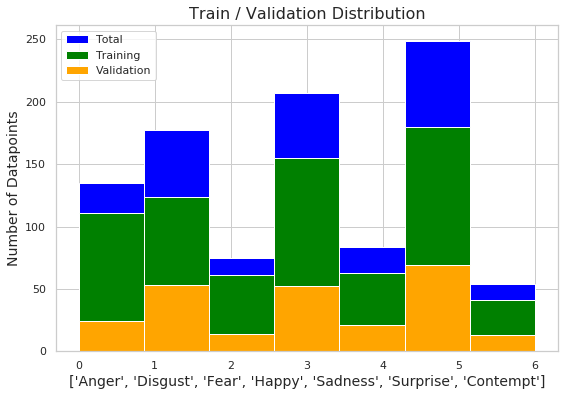

In [6]:
# Taking a Look at a Train-Validation Split
plt.figure(figsize = (9, 6) )
plt.xlabel(emotion_labels_ck, size = 14)
plt.ylabel('Number of Datapoints', size = 14)
plt.hist(y_CK, bins = 7, color = 'blue')
plt.hist(y_train, bins = 7, color = 'green');
plt.hist(y_test, bins = 7, color = 'orange');
plt.legend(['Total', 'Training', 'Validation'])
plt.title("Train / Validation Distribution", size = 16);

plt.show()

As we can see from the Histogram above, there is an insufficient amount of labeled data for Fear, Sadness and Contempt, meaning a trained model might not generalize well for previously unseen examples with these labels.

# CK+: ConvNet using Keras (TF2)

In [7]:
# Reshape and Normalize inputs to a CNN.
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_train = np.float32(X_train) / X_train.max()
y_train = tf.keras.utils.to_categorical(y_train)

X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)
X_test = np.float32(X_test) / X_test.max()
y_test = tf.keras.utils.to_categorical(y_test)

In [43]:
model_ck = tf.keras.models.Sequential([
    
        tf.keras.layers.InputLayer(input_shape = (48, 48, 1)),
    
        # Dataset Augmentation
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.25),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    
        tf.keras.layers.Conv2D(32, kernel_size = (4, 4), padding = "same"),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, kernel_size = (1, 1), padding = "same"),     
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, kernel_size = (4, 4), padding = "same"),     
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same"),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, kernel_size = (1, 1), padding = "same"),     
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same"),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.5),
    
        tf.keras.layers.Conv2D(128, kernel_size = (2, 2), padding = "same"),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, kernel_size = (1, 1), padding = "same"),     
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, kernel_size = (2, 2), padding = "same"),     
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size = (2, 2)),
        tf.keras.layers.Dropout(0.5),
    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation = 'relu'),
        tf.keras.layers.Dense(512, activation = 'relu'),
        tf.keras.layers.Dense(256, activation = 'relu'),    
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(7, activation = 'softmax')
])

model_ck.compile(optimizer = tf.optimizers.Adam(), loss = 'categorical_crossentropy', metrics = [tf.keras.metrics.CategoricalAccuracy()])
model_ck_hist = model_ck.fit(X_train, y_train, batch_size = 10, epochs = 80, validation_data = (X_test, y_test))

Epoch 1/80
74/74 [==============================] - 7s 95ms/step - loss: 3.0895 - categorical_accuracy: 0.2054 - val_loss: 2.0941 - val_categorical_accuracy: 0.0976
Epoch 2/80
74/74 [==============================] - 7s 93ms/step - loss: 1.9508 - categorical_accuracy: 0.2163 - val_loss: 2.1372 - val_categorical_accuracy: 0.0976
Epoch 3/80
74/74 [==============================] - 7s 93ms/step - loss: 1.8958 - categorical_accuracy: 0.2476 - val_loss: 1.8898 - val_categorical_accuracy: 0.2805
Epoch 4/80
74/74 [==============================] - 7s 99ms/step - loss: 1.8668 - categorical_accuracy: 0.2299 - val_loss: 2.5977 - val_categorical_accuracy: 0.0528
Epoch 5/80
74/74 [==============================] - 8s 109ms/step - loss: 1.8511 - categorical_accuracy: 0.2327 - val_loss: 2.4068 - val_categorical_accuracy: 0.0528
Epoch 6/80
74/74 [==============================] - 8s 109ms/step - loss: 1.8638 - categorical_accuracy: 0.2272 - val_loss: 2.1054 - val_categorical_accuracy: 0.0528
Epoch 7/

# CK+: Evaluation
Let's now see what accuracy we ended up with after training for 80 epochs.

In [44]:
model_ck.evaluate(X_test, y_test)

8/8 [==============================] - 0s 32ms/step - loss: 0.7709 - categorical_accuracy: 0.6301


[0.770854115486145, 0.630081295967102]

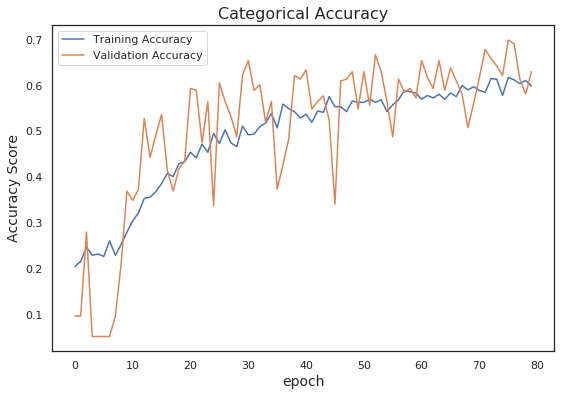

In [45]:
# Training vs Validation Accuracies
plt.figure(figsize = (9, 6))

plt.plot(model_ck_hist.history['categorical_accuracy'])
plt.plot(model_ck_hist.history['val_categorical_accuracy']);
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('epoch', size = 14)
plt.ylabel('Accuracy Score', size = 14)
plt.title('Categorical Accuracy', size = 16)
plt.show()


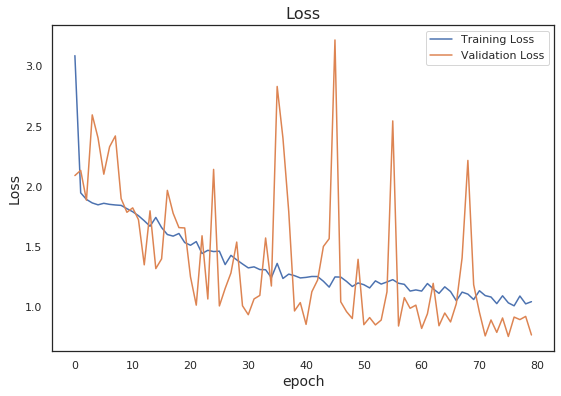

In [46]:
# Training vs Validation Loss
plt.figure(figsize = (9, 6))

plt.plot(model_ck_hist.history['loss'])
plt.plot(model_ck_hist.history['val_loss']);
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('epoch', size = 14)
plt.ylabel('Loss', size = 14)
plt.title('Loss', size = 16)
plt.show()

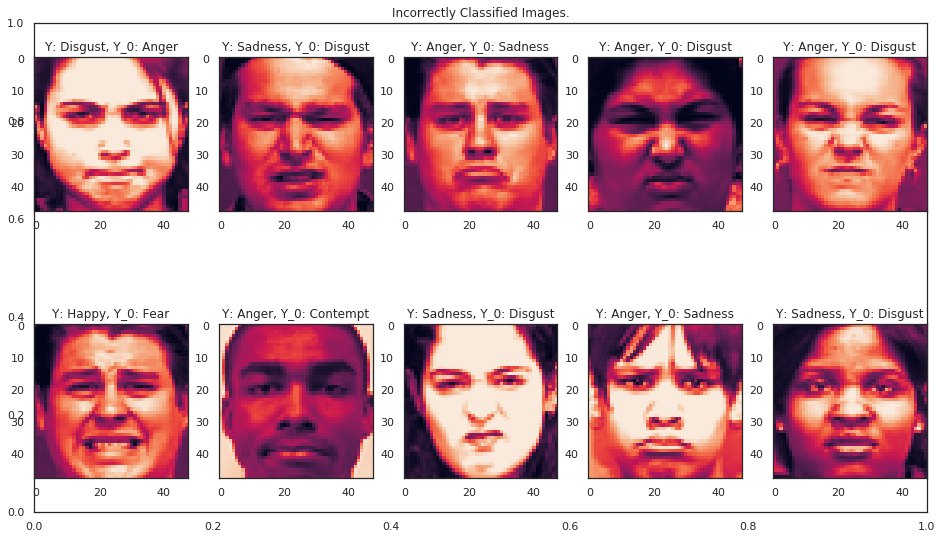

In [47]:
# Wrongly Classified Images.
sns.set_style(style = 'white')

pred = model_ck.predict_classes(X_test);

figure = plt.figure(figsize = (16, 9))

i = 0
imgcount = 1
plt.title('Incorrectly Classified Images.')

while imgcount < 11:
    
    if(y_test[i].argmax() != pred[i]):
        figure.add_subplot(2, 5, imgcount)
        plt.imshow(X_test[i].reshape((48, 48)))
        imgcount += 1
        plt.title('Y: '+ emotion_labels_ck[pred[i]] +  ', Y_0: ' + emotion_labels_ck[y_test[i].argmax()])
        
    i += 1
    
plt.show()

## Confusion Matrix

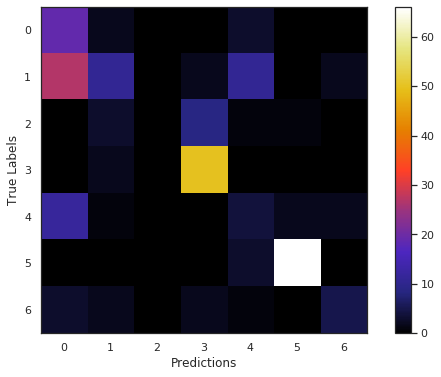

In [48]:
# Plotting a confusion matrix.
ck_conf = tf.math.confusion_matrix(y_test_labels, pred, num_classes = 7)

plt.figure(figsize = (10, 6))
plt.imshow(ck_conf, cmap = 'CMRmap')
plt.ylabel('True Labels')
plt.xlabel('Predictions')
plt.colorbar()

plt.show()

Plotting a confusion matrix reveals the expected performance of a CNN trained on CK+ Dataset.

It is evident that a model fails to classify completely or confuses the following Emotions:
- Fear
- Sadness
- Contempt
- Happy
- Disgust
- Anger

Does relatively better on:
- Surprise

The unfortunate result, as evident on a post-split histogram, is likely due to poor variety of labeled data available.<br>
After some trial, dataset Augmentation helps to improve the score, however it is unsufficient.

In [49]:
model_ck.save("ck_model_63.h5")

# FER+ Dataset: Loading

In [50]:
from io import StringIO

def parsePixels(pixelString):
    data = pixelString.split(" ")
        
    return data


# Loads the dataset, optionally saving the images.
def loadFER():
    fer_data = getFER()
    
# Transforms and saves the data Locally in a PNG format.

#     fer_training = fer_data[fer_data['Usage'] == 'Training']    
#     fer_validation_private = fer_data[fer_data['Usage'] == 'PrivateTest']
#     fer_validation_public = fer_data[fer_data['Usage'] == 'PublicTest']
    
#     # Save Training Images Locally
#     for idx, each in enumerate(fer_training['pixels']):
#         fer_training['pixels'].values[idx] =  np.asarray(fer_training['pixels'][idx]).reshape(48, 48)
#         img = PIL.Image.fromarray(fer_training['pixels'][idx])
#         img.save('../Datasets/FER2013/FER_TRAIN/' + 'fer_train_' + str(idx) + '.png')
        
#     # Save Training Labels
#     fer_training_y = fer_training['emotion']

#     # Save Validation Images (Private)
#     for idx, each in enumerate(fer_validation_private['pixels']):
#         fer_validation_private['pixels'].iloc[idx] = np.asarray(fer_validation_private['pixels'].iloc[idx]).reshape(48, 48)
#         img = PIL.Image.fromarray(fer_validation_private['pixels'].iloc[idx])
#         img.save('../Datasets/FER2013/FER_VAL_PRIVATE/' + 'fer_val_private_' + str(idx) + '.png')
        
#     # Save Validation Labels (Private)    
#     fer_validation_private_y = fer_validation_private['emotion']    
        
#     # Save Validation Images (Public)
#     for idx, each in enumerate(fer_validation_public['pixels']):
#         fer_validation_public['pixels'].iloc[idx] = np.asarray(fer_validation_public['pixels'].iloc[idx]).reshape(48, 48)
#         img = PIL.Image.fromarray(fer_validation_public['pixels'].iloc[idx])
#         img.save('../Datasets/FER2013/FER_VAL_PUBLIC/' + 'fer_val_public' + str(idx) + '.png')
        
#     # Save Validation Labels (Public)    
#     fer_validation_public_y = fer_validation_public['emotion']    
    
    # Prepare data
    pixels = fer_data['pixels'].tolist()
    parsed_pixels = []
    
    for pix_sequence in pixels:
        picture = parsePixels(pix_sequence)
        picture = np.asarray(picture, dtype = np.uint8).reshape(48, 48)
        parsed_pixels.append(picture)

    parsed_pixels = np.asarray(parsed_pixels)
    parsed_pixels = np.expand_dims(parsed_pixels, -1)
    
    emotion_labels = np.matrix(fer_data['emotion'])
    emotion_labels = emotion_labels.reshape(emotion_labels.shape[1], 1)
    
    return parsed_pixels, emotion_labels

# Get the raw data as supplied
def getFER():
    fer_data = pd.read_csv('../Datasets/fer2013.csv')
    
    return fer_data
    

In [51]:
# Get FER+ Dataset
# Uncomment The Local Saving Part in loadFER() to save images locally.
fer_pixels, fer_labels = loadFER()

I am using a 90/10 Train/Validation split. The FER+ dataset is large and has around 33 thousand images.<br>
Having more data to train on is a goal, so only 10% for Validation will suffice.

In [52]:
# Performs the split
X_train, y_train, X_test, y_test = splitTrainValidate(fer_pixels, fer_labels, 0.9)

print("Training Data: ", X_train.shape)
print("Training Labels", y_train.shape)
print("Validation Data: ", X_test.shape)
print("Validation Labels: ",y_test.shape)

Training Data:  (32298, 48, 48, 1)
Training Labels (32298, 1)
Validation Data:  (3589, 48, 48, 1)
Validation Labels:  (3589, 1)


In [53]:
emotion_labels_fer = ['Fear', 'Disgust', 'Anger' ,'Happiness' , 'Sadness', 'Surprise','Neutral']

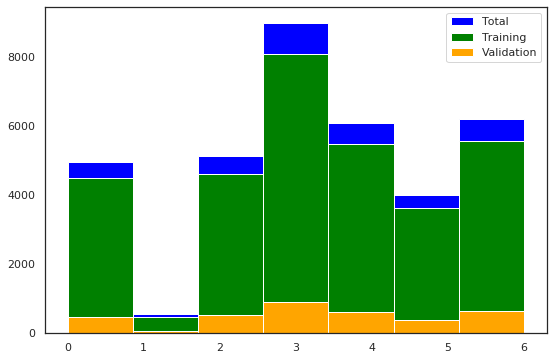

In [54]:
plt.figure(figsize = (9, 6))
plt.hist(fer_labels, bins = 7, color = 'blue')
plt.hist(y_train, bins = 7, color = 'green')
plt.hist(y_test, bins = 7, color = 'orange')
plt.legend(['Total', 'Training', 'Validation'])

As we can see from the post-spit dataset, there an inadequately small amount of labeled data for emotion of Disgust.<br>
We can not trust any predictions the model makes regarding this label.

# FER+: ConvNet using Keras (TF2)

In [55]:
# Prepare inputs.
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_train = np.float32(X_train) / X_train.max()
y_train = tf.keras.utils.to_categorical(y_train)

X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)
X_test = np.float32(X_test) / X_test.max()
y_test = tf.keras.utils.to_categorical(y_test)

In [56]:
# ConvNet Architecture and Training
model = tf.keras.models.Sequential([
    
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.15),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.25),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    
        tf.keras.layers.Conv2D(32, kernel_size = (4, 4), padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(32, kernel_size = (1, 1), padding = "same"),     
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(32, kernel_size = (4, 4), padding = "same"),     
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2)),
        tf.keras.layers.Dropout(0.5),
    
        tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(64, kernel_size = (1, 1), padding = "same"),     
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same"),     
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2)),
        tf.keras.layers.Dropout(0.5),
    
        tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same"),    
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(128, kernel_size = (1, 1), padding = "same"),    
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same"),    
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2)),
        tf.keras.layers.Dropout(0.5),
    
        tf.keras.layers.Conv2D(256, kernel_size = (2, 2), padding = "same"),    
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(256, kernel_size = (1, 1), padding = "same"),    
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(256, kernel_size = (2, 2), padding = "same"),    
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = (1, 1)),
        tf.keras.layers.Dropout(0.5),
    
        tf.keras.layers.Conv2D(512, kernel_size = (2, 2), padding = "same"),    
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(512, kernel_size = (1, 1), padding = "same"),    
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Conv2D(512, kernel_size = (2, 2), padding = "same"),    
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = (2, 2)),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation = 'relu'),
        tf.keras.layers.Dense(512, activation = 'relu'),
    
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(7, activation = 'softmax')
])

model.compile(optimizer = tf.optimizers.Adam(), loss = 'categorical_crossentropy', metrics = [tf.keras.metrics.CategoricalAccuracy()])
model_log = model.fit(X_train, y_train, batch_size = 64, epochs = 100, validation_data = (X_test, y_test))


Epoch 1/100
505/505 [==============================] - 374s 740ms/step - loss: 1.8902 - categorical_accuracy: 0.2332 - val_loss: 1.8555 - val_categorical_accuracy: 0.2527
Epoch 2/100
505/505 [==============================] - 371s 735ms/step - loss: 1.8095 - categorical_accuracy: 0.2455 - val_loss: 1.8229 - val_categorical_accuracy: 0.2527
Epoch 3/100
505/505 [==============================] - 367s 727ms/step - loss: 1.8021 - categorical_accuracy: 0.2471 - val_loss: 1.8435 - val_categorical_accuracy: 0.2502
Epoch 4/100
505/505 [==============================] - 367s 726ms/step - loss: 1.7992 - categorical_accuracy: 0.2500 - val_loss: 1.8602 - val_categorical_accuracy: 0.2349
Epoch 5/100
505/505 [==============================] - 368s 729ms/step - loss: 1.7917 - categorical_accuracy: 0.2528 - val_loss: 1.8085 - val_categorical_accuracy: 0.2527
Epoch 6/100
505/505 [==============================] - 368s 729ms/step - loss: 1.7833 - categorical_accuracy: 0.2586 - val_loss: 1.8386 - val_cat

Epoch 49/100
505/505 [==============================] - 371s 734ms/step - loss: 1.2633 - categorical_accuracy: 0.5176 - val_loss: 1.2118 - val_categorical_accuracy: 0.5397
Epoch 50/100
505/505 [==============================] - 373s 738ms/step - loss: 1.2590 - categorical_accuracy: 0.5190 - val_loss: 1.1673 - val_categorical_accuracy: 0.5603
Epoch 51/100
505/505 [==============================] - 373s 738ms/step - loss: 1.2529 - categorical_accuracy: 0.5250 - val_loss: 1.1918 - val_categorical_accuracy: 0.5475
Epoch 52/100
505/505 [==============================] - 372s 738ms/step - loss: 1.2553 - categorical_accuracy: 0.5219 - val_loss: 1.1897 - val_categorical_accuracy: 0.5531
Epoch 53/100
505/505 [==============================] - 378s 748ms/step - loss: 1.2486 - categorical_accuracy: 0.5247 - val_loss: 1.1760 - val_categorical_accuracy: 0.5461
Epoch 54/100
505/505 [==============================] - 375s 742ms/step - loss: 1.2513 - categorical_accuracy: 0.5241 - val_loss: 1.1810 - v

# FER+: Evaluation

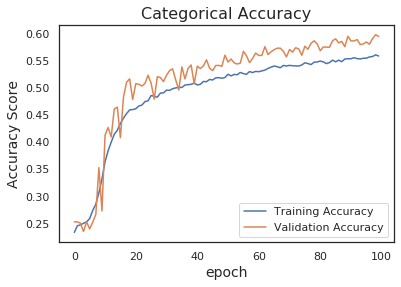

In [57]:
plt.plot(model_log.history['categorical_accuracy'])
plt.plot(model_log.history['val_categorical_accuracy']);
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('epoch', size = 14)
plt.ylabel('Accuracy Score', size = 14)
plt.title('Categorical Accuracy', size = 16)
plt.show()

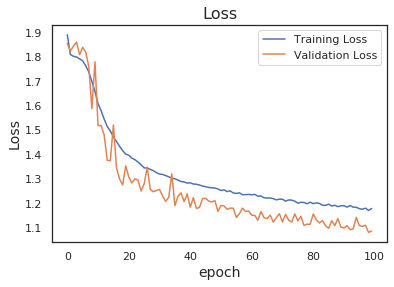

In [58]:
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss']);
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('epoch', size = 14)
plt.ylabel('Loss', size = 14)
plt.title('Loss', size = 16)
plt.show()

In [59]:
model.evaluate(X_test, y_test)

113/113 [==============================] - 6s 57ms/step - loss: 1.0876 - categorical_accuracy: 0.5949


[1.0875755548477173, 0.5948732495307922]

In [63]:
# Saves Validation predictions.
y_fer_unchanged = []
for idx, each in enumerate(y_test):
    y_fer_unchanged.append(np.argmax(each))

fer_prediction = model.predict_classes(X_test)

## Confusion Matrix

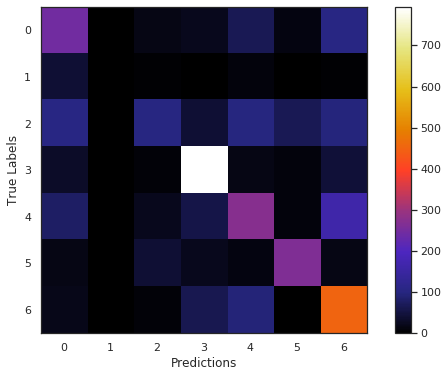

In [64]:
# Plotting a confusion matrix.
fer_conf = tf.math.confusion_matrix(y_fer_unchanged, fer_prediction, num_classes = 7)

plt.figure(figsize = (10, 6))
plt.imshow(fer_conf, cmap = 'CMRmap')
plt.ylabel('True Labels')
plt.xlabel('Predictions')
plt.colorbar()

plt.show()

As we can observe from Confusion Matrix plotted for the CNN trained on a FER+ Dataset, the results are as unsatisfying as the previous model is.

In [65]:
model.save("fer_model_59.h5")